In [5]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import statsmodels.api as sm
from statsmodels.formula.api import glm
from sklearn import metrics
import pickle

/home/lab.analytics.northwestern.edu/mpauleen/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
hist = pd.read_csv('../data/raw/historical.csv')

In [11]:
def parse_dates(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

In [6]:
def rush_hour_indicator(df):
    df['am_rush'] = ((df.ts.dt.hour >= 7) & (df.ts.dt.hour < 11)).astype(int)
    df['pm_rush'] = ((df.ts.dt.hour >= 16) & (df.ts.dt.hour < 19)).astype(int)

In [7]:
def weekend_indicator(df):
    df['weekend'] = (df.ts.dt.weekday >= 5).astype(int)

In [8]:
def holiday_indicator(df):
    min_date = df.ts.min()
    max_date = df.ts.max()
    cal = calendar()
    holidays = cal.holidays(start=min_date, end=max_date)
    df['holiday'] = (df.ts.dt.date.astype('datetime64').isin(holidays)).astype(int)


In [12]:
hist['ts'] = parse_dates(hist.Timestamp)
holiday_indicator(hist)
weekend_indicator(hist)
rush_hour_indicator(hist)
hist['weekend_or_holiday'] = (hist['weekend'] | hist['holiday']).astype(int)
hist['month'] = hist.ts.dt.month

/home/lab.analytics.northwestern.edu/mpauleen/.local/lib/python3.5/site-packages/pandas/core/internals.py:3462: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return self.apply('astype', dtype=dtype, **kwargs)


In [13]:
hist['shortage'] = hist['Available Bikes'] <= 0

In [14]:
sorted_hist = hist.sort_values(by = ['ID','ts'])

In [15]:
by_id = sorted_hist.groupby('ID')

In [16]:
sorted_hist['shortage_in_30'] = (by_id.shortage.shift(-1) | by_id.shortage.shift(-2) | by_id.shortage.shift(-3)).astype(int)
sorted_hist['percent_full_lag'] = by_id['Percent Full'].shift(1)
sorted_hist['percent_full_delta'] = sorted_hist['percent_full_lag']-sorted_hist['Percent Full']

In [174]:
s2 = sorted_hist[sorted_hist.ID == 7]

In [175]:
model = glm('shortage_in_30 ~ C(month)+Q("Percent Full")+weekend_or_holiday+am_rush+pm_rush+percent_full_delta', data=s2, family=sm.families.Binomial())

In [176]:
x = model.fit()

In [177]:
x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         shortage_in_30   No. Observations:                52338
Model:                            GLM   Df Residuals:                    52321
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -3306.3
Date:                Sat, 10 Mar 2018   Deviance:                       6612.7
Time:                        16:37:04   Pearson chi2:                 3.96e+05
No. Iterations:                    28                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.5050      0.335     -4.494      0.000      -2.161      -0.849
C(month)[T.2]          1.2874      0.345      3.732      0.000       0.611       1.964
C(month)[T.3]         -0.0840      0.457     -0.184      0.854      -0.980       0.813
C(month)[T.4]          1.2537      0.345      3.630      0.000       0.577       1.931
C(month)[T.5]          1.2161      0.339      3.586      0.000       0.551       1.881
C(month)[T.6]          2.0298      0.337      6.021      0.000       1.369       2.691
C(month)[T.7]          1.7633      0.335      5.268      0.000       1.107       2.419
C(month)[T.8]          1.9868      0.336      5.909      0.000       1.328       2.646
C(month)[T.9]          2.2616      0.340      6.648      0.000       1.595       2.928
C(month)[T.10]         1.1313      0.345      3.283      0.001       0.456       1.807
C(month)[T.11]       -22.8065    1.7e+04     -0.001      0.999   -3.34e+04    3.33e+04
C(month)[T.12]        -0.3799      0.392     -0.969      0.333      -1.149       0.389
Q("Percent Full")     -0.1857      0.004    -44.274      0.000      -0.194      -0.177
weekend_or_holiday     0.6984      0.067     10.466      0.000       0.568       0.829
am_rush                0.5671      0.080      7.126      0.000       0.411       0.723
pm_rush                0.0331      0.091      0.364      0.716      -0.145       0.211
percent_full_delta     0.0074      0.006      1.296      0.195      -0.004       0.019
======================================================================================
"""

In [178]:
fpr, tpr, thresh = metrics.roc_curve(s2.shortage_in_30[1:], x.predict())

In [188]:
metrics.roc_auc_score(s2.shortage_in_30[1:], x.predict())

0.9775987232575467

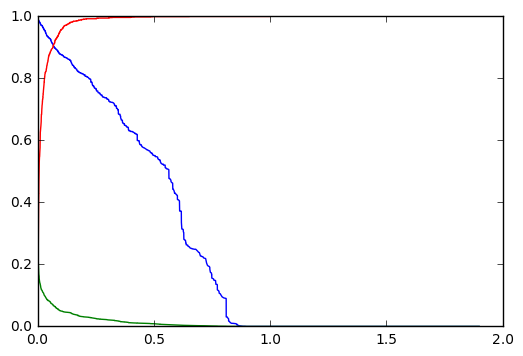

In [179]:
plt.plot(thresh, tpr)
plt.plot(thresh, fpr)
plt.plot(fpr, tpr)


(array([46967.,  1156.,  1016.,   517.,   535.,   368.,   366.,   653.,
          285.,   475.]),
 array([2.86473048e-12, 8.84402863e-02, 1.76880573e-01, 2.65320859e-01,
        3.53761145e-01, 4.42201431e-01, 5.30641718e-01, 6.19082004e-01,
        7.07522290e-01, 7.95962576e-01, 8.84402863e-01]),
 <a list of 10 Patch objects>)

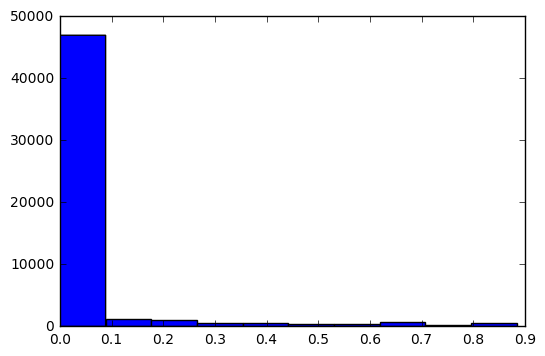

In [160]:
plt.hist(x.predict())

In [21]:
s1 = hist[hist.ID == 36]

In [17]:
zeros = hist[hist['Available Vi'] <= 0]

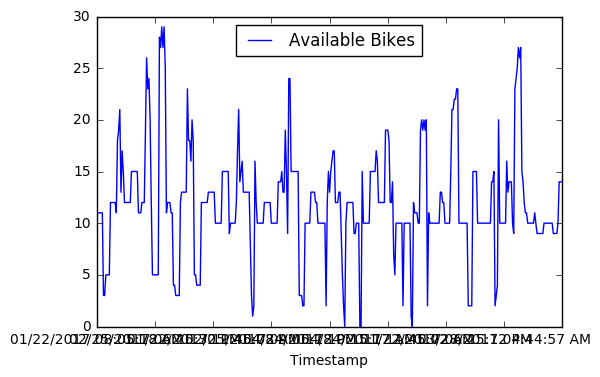

In [42]:
hist[hist.ID == 100 &].head(400).plot(x = 'Timestamp', y = 'Available Bikes')
plt.show()

Model Building Loop

In [183]:
unique_ids = sorted_hist.ID.unique()
station_models = dict.fromkeys(unique_ids)

In [184]:
for station_id in unique_ids:
    model = glm('shortage_in_30 ~ C(month)+Q("Percent Full")+weekend_or_holiday+am_rush+pm_rush+percent_full_delta', data=sorted_hist[sorted_hist.ID == station_id], family=sm.families.Binomial())
    station_models[station_id] = model.fit()

In [190]:
model_auc = dict.fromkeys(unique_ids)

for station_id in unique_ids:
    model_auc[station_id] = metrics.roc_auc_score(sorted_hist[sorted_hist.ID == station_id].shortage_in_30[1:], station_models[station_id].predict())

In [193]:

with open('models.pickle', 'wb') as handle:
    pickle.dump(station_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

# API Data Collection

In [20]:
import sodapy
import pandas as pd

In [21]:
client = sodapy.Socrata("data.cityofchicago.org", None)

In [23]:
id = 200

In [6]:
results_df.dtypes

address             object
available_bikes     object
available_docks     object
docks_in_service    object
id                  object
latitude            object
location            object
longitude           object
percent_full        object
record              object
station_name        object
status              object
timestamp           object
total_docks         object
dtype: object

In [24]:
results = client.get("eq45-8inv", id = id, limit = 2000, where = "timestamp > '{}'".format(x))
results_df = pd.DataFrame.from_records(results)
print(results_df)

                 address available_bikes available_docks docks_in_service  \
0    MLK Jr Dr & 47th St               1              10               11   
1    MLK Jr Dr & 47th St               1              10               11   
2    MLK Jr Dr & 47th St               1              10               11   
3    MLK Jr Dr & 47th St               1              10               11   
4    MLK Jr Dr & 47th St               1              10               11   
5    MLK Jr Dr & 47th St               1              10               11   
6    MLK Jr Dr & 47th St               1              10               11   
7    MLK Jr Dr & 47th St               1              10               11   
8    MLK Jr Dr & 47th St               1              10               11   
9    MLK Jr Dr & 47th St               1              10               11   
10   MLK Jr Dr & 47th St               1              10               11   
11   MLK Jr Dr & 47th St               1              10               11   

In [1]:
import datetime

In [4]:
datetime.datetime.now().strftime("%y-%m-%d %H")

'18-02-22 13'

In [16]:
x = (datetime.datetime.now()-datetime.timedelta(days = 1)).strftime("%Y-%m-%dT%H:%M:%S")

In [17]:
x

'2018-02-21T13:54:46'